In [1]:
import numpy as np
import pandas as pd
# import volpriceinference as vl
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm
from functools import partial

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
kharpov = False

In [5]:
if kharpov:
    true_params = {'theta': 0.50, 
               'pi': -7,
               'phi': -.3,
               'scale': .1,
               'delta': 1.11,
               'rho': .4,
              }
else:
     true_params ={'delta': 0.27,
                   'rho': 0.81,
                   'scale': 3.11,
                   'phi': -.01,
                   'pi': -.2,
                   'theta': .53}
    
time_dim = 37000
sim_dim = 500
innov_dim = 250

In [6]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(**true_params),
     'beta':vl.compute_beta(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                    pi=true_params['pi'], theta=true_params['theta']),
     'psi':vl.compute_psi(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                  theta=true_params['theta']),
      'zeta': 1 - true_params['phi']**2})

In [7]:
vl.compute_gamma(**true_params)

0.004627006643545641

In [8]:
total_true_params

{'delta': 0.27,
 'rho': 0.81,
 'scale': 3.11,
 'phi': -0.01,
 'pi': -0.2,
 'theta': 0.53,
 'gamma': 0.004627006643545641,
 'beta': 0.005835352140868055,
 'psi': -0.03421183442037379,
 'zeta': 0.9999}

In [9]:
true_params

{'delta': 0.27,
 'rho': 0.81,
 'scale': 3.11,
 'phi': -0.01,
 'pi': -0.2,
 'theta': 0.53}

In [10]:
total_true_params

{'delta': 0.27,
 'rho': 0.81,
 'scale': 3.11,
 'phi': -0.01,
 'pi': -0.2,
 'theta': 0.53,
 'gamma': 0.004627006643545641,
 'beta': 0.005835352140868055,
 'psi': -0.03421183442037379,
 'zeta': 0.9999}

## We start by examining the distributions of simulated data

In [11]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [ ]:
omega, omega_cov = vl.estimate_params(data)

In [ ]:
omega

{'gamma': 0.004614451429674272,
 'beta': 0.005900243988004419,
 'psi': -0.031444238369545637,
 'zeta': 0.9975231300294848,
 'delta': 0.2695815632420677,
 'rho': 0.8105622288572095,
 'scale': 3.1331544340003497}

In [ ]:
omega_cov

,beta,delta,gamma,psi,rho,scale,zeta
beta,3.482646e-09,0.000000,-2.911230e-09,-2.830781e-09,0.000000,0.000000,0.000000
delta,0.000000e+00,0.000032,0.000000e+00,0.000000e+00,-0.000018,-0.000066,0.000000
gamma,-2.911230e-09,0.000000,1.092593e-08,4.647658e-10,0.000000,0.000000,0.000000
psi,-2.830781e-09,0.000000,4.647658e-10,6.040108e-06,0.000000,0.000000,0.000000
rho,0.000000e+00,-0.000018,0.000000e+00,0.000000e+00,0.000045,-0.000038,0.000000
scale,0.000000e+00,-0.000066,0.000000e+00,0.000000e+00,-0.000038,0.002390,0.000000
zeta,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000054


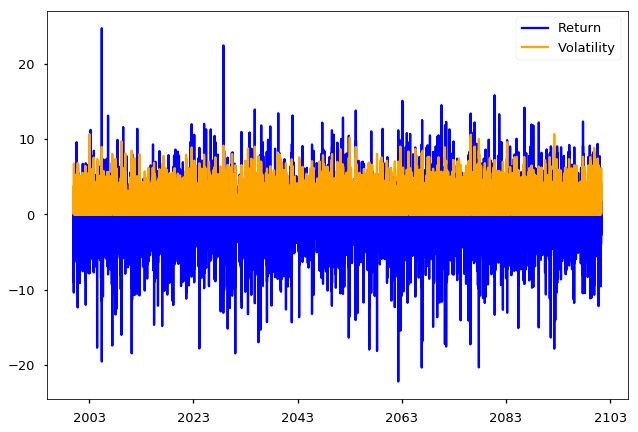

In [ ]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [ ]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,2.337103,-0.343901
rtn,-0.343901,4.528346


In [ ]:
total_true_params

{'delta': 0.27,
 'rho': 0.81,
 'scale': 3.11,
 'phi': -0.01,
 'pi': -0.2,
 'theta': 0.53,
 'gamma': 0.004627006643545641,
 'beta': 0.005835352140868055,
 'psi': -0.03421183442037379,
 'zeta': 0.9999}

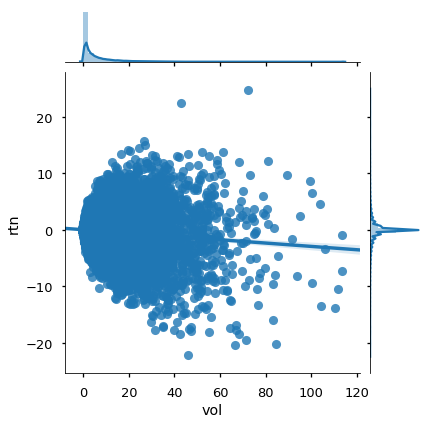

In [ ]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [ ]:
true_params['delta']

0.27

In [ ]:
true_params['scale']

3.11

In [ ]:
data.describe()

,vol,rtn
count,37000.000000,37000.000000
mean,4.465993,-0.109475
std,8.623261,2.127991
min,0.000010,-22.150768
25%,0.066929,-0.532422
50%,0.920316,0.004679
75%,4.812757,0.420345
max,113.414052,24.681062


## I now estimate all of the parameters

In [ ]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [ ]:
estimator = partial(vl.estimate_params_strong_id, case=1)

In [ ]:
estimator(data_arr[0])

({'gamma': 0.004724808202387004,
  'beta': 0.005779737963138137,
  'psi': -0.03644169966933361,
  'zeta': 1.000354706100247,
  'delta': 0.26032638694762494,
  'rho': 0.81989144374877,
  'scale': 3.1543347147890852,
  'phi': 0.0,
  'pi': -0.1,
  'theta': 0.0},
                beta     delta         gamma           phi   pi           psi  \
 beta   3.022491e-09  0.000000 -2.589090e-09           NaN  NaN -2.454863e-09   
 delta  0.000000e+00  0.000034  0.000000e+00           NaN  NaN  0.000000e+00   
 gamma -2.589090e-09  0.000000  1.069723e-08           NaN  NaN  2.436936e-10   
 phi             NaN       NaN           NaN  3.905775e-09  0.0           NaN   
 pi              NaN       NaN           NaN  0.000000e+00  0.0           NaN   
 psi   -2.454863e-09  0.000000  2.436936e-10           NaN  NaN  5.930992e-06   
 rho    0.000000e+00 -0.000020  0.000000e+00           NaN  NaN  0.000000e+00   
 scale  0.000000e+00 -0.000075  0.000000e+00           NaN  NaN  0.000000e+00   
 theta     

In [ ]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [ ]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [ ]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, delta=true_params['delta'],
                                                   rho=true_params['rho'], scale=true_params['scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

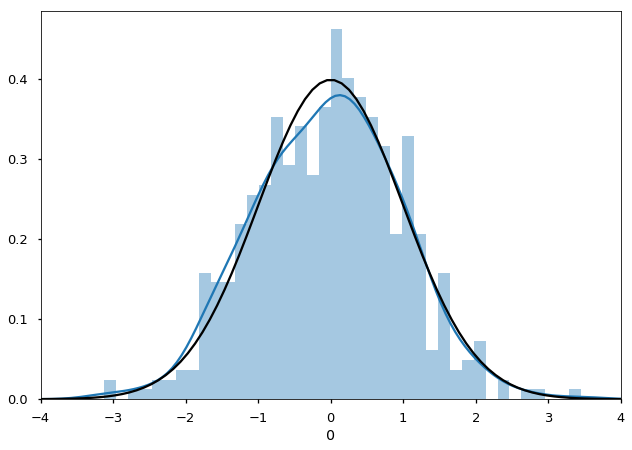

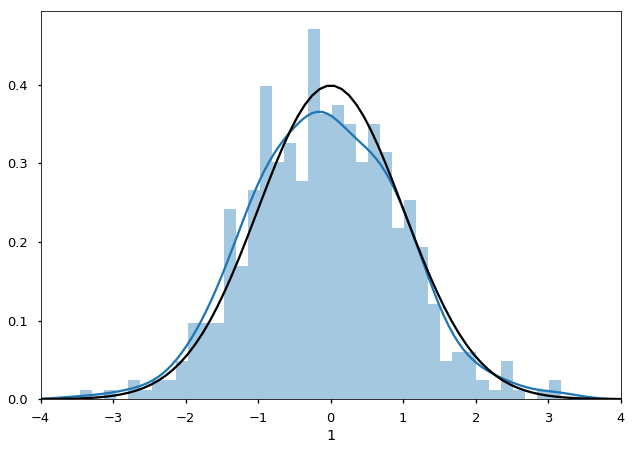

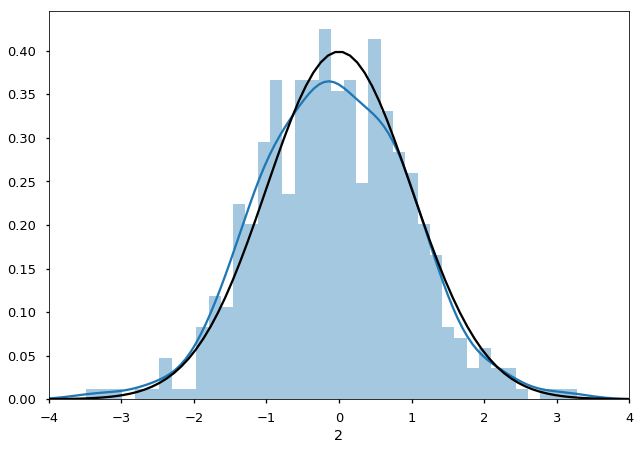

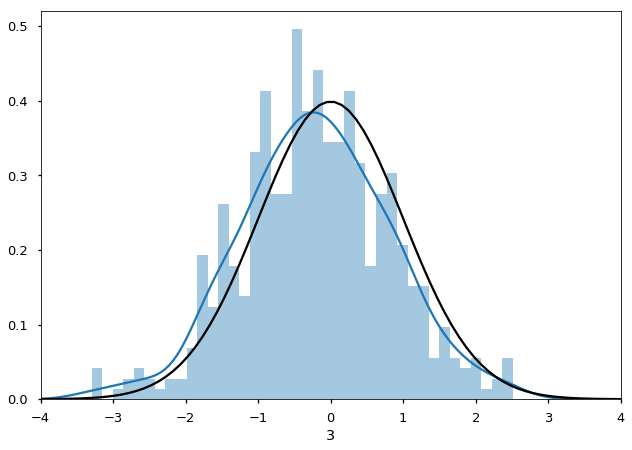

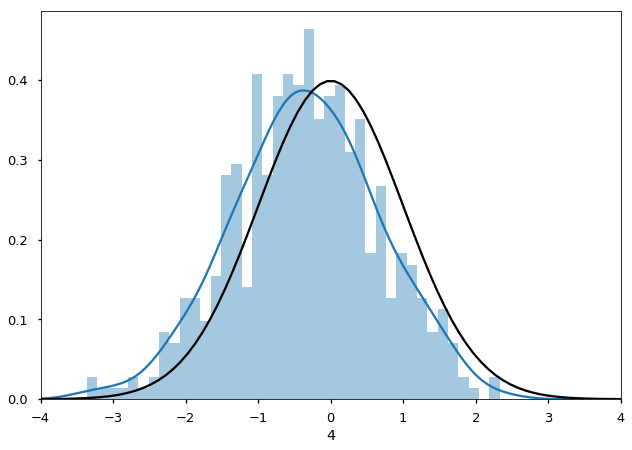

In [ ]:
for name, moment in moment_data.items():
    moment_fig, moment_ax = mpl.pyplot.subplots()
    sns.distplot(moment, ax=moment_ax, bins=40)
    moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    moment_ax.set_xlim([-4,4])

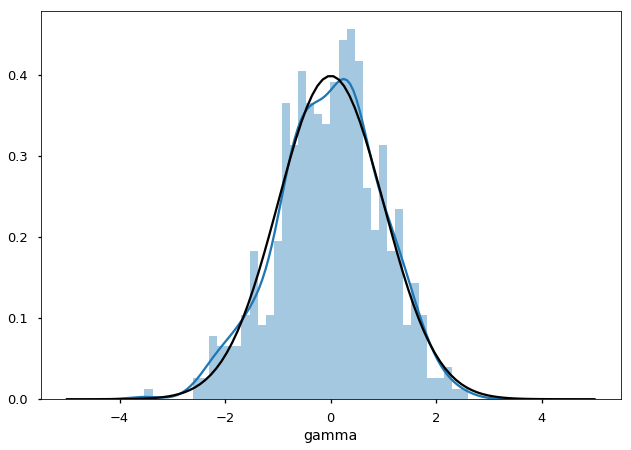

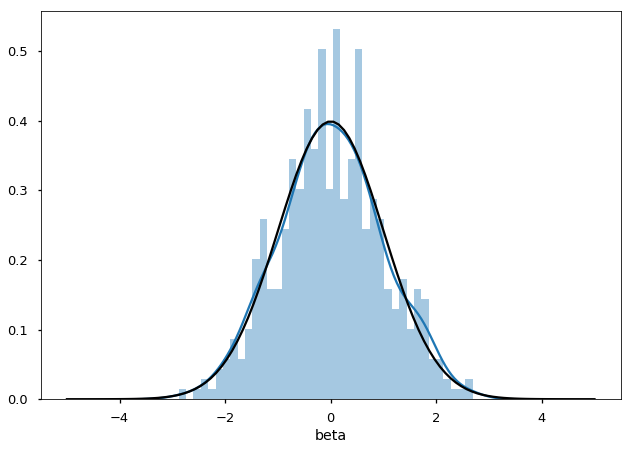

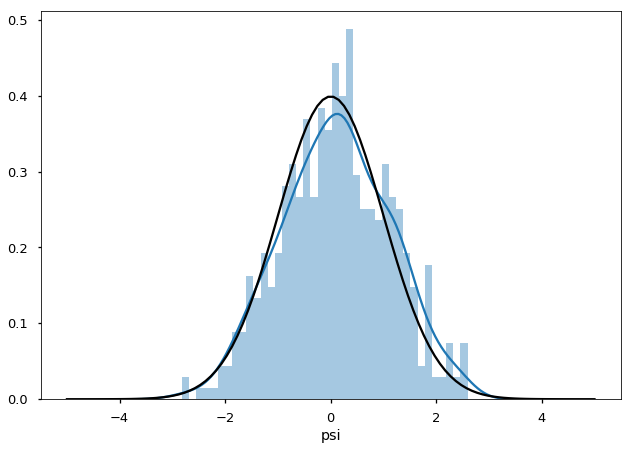

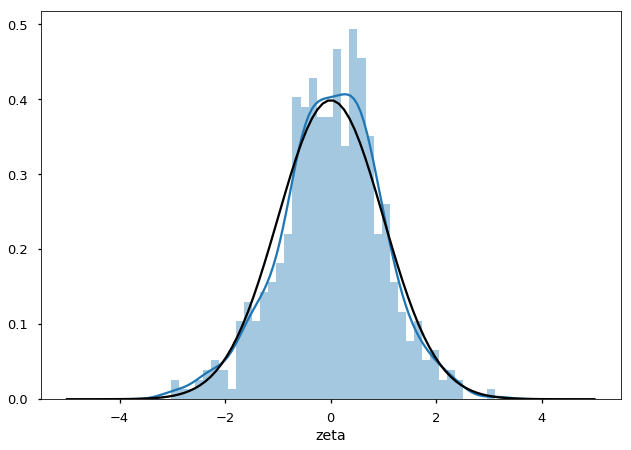

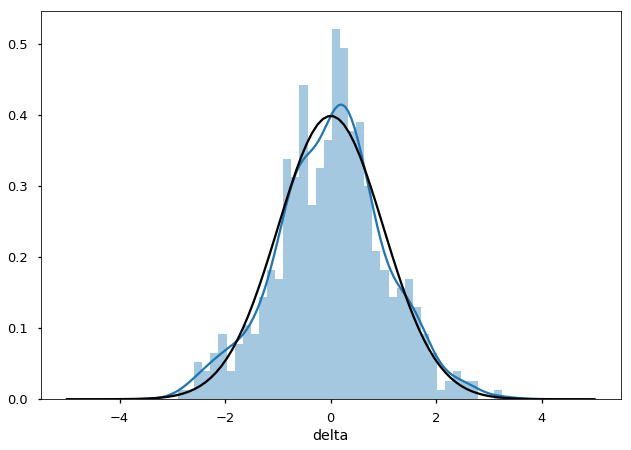

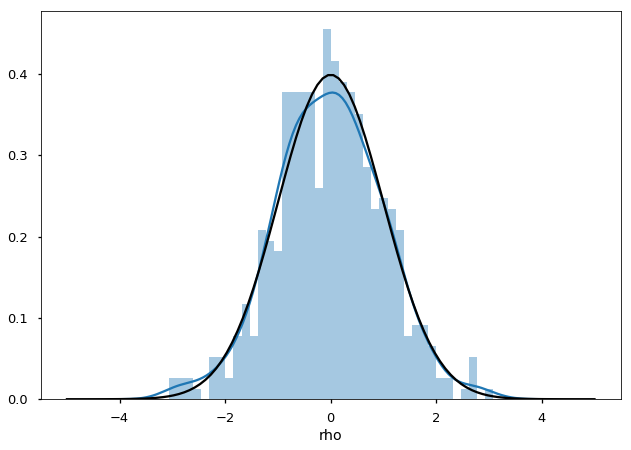

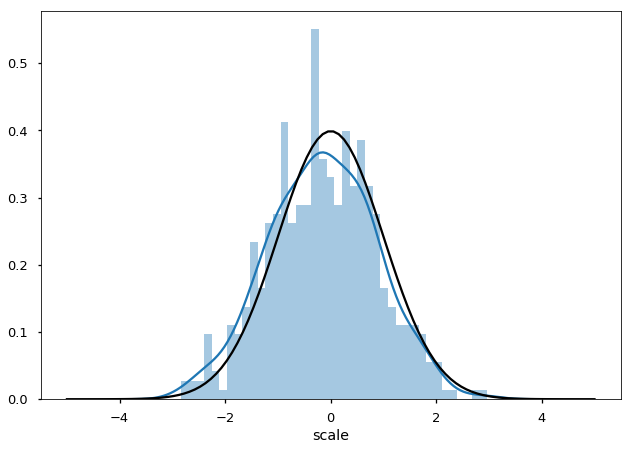

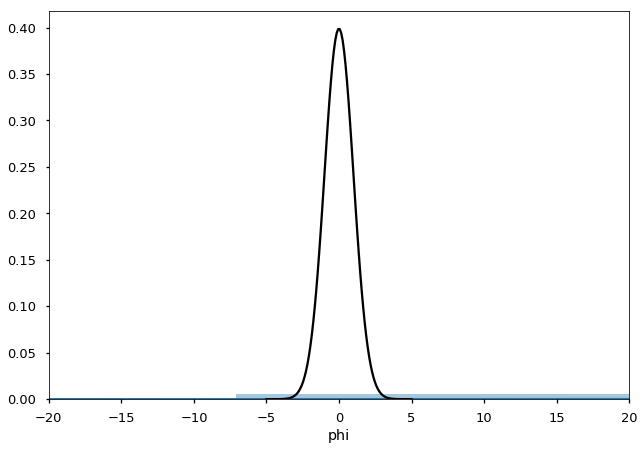

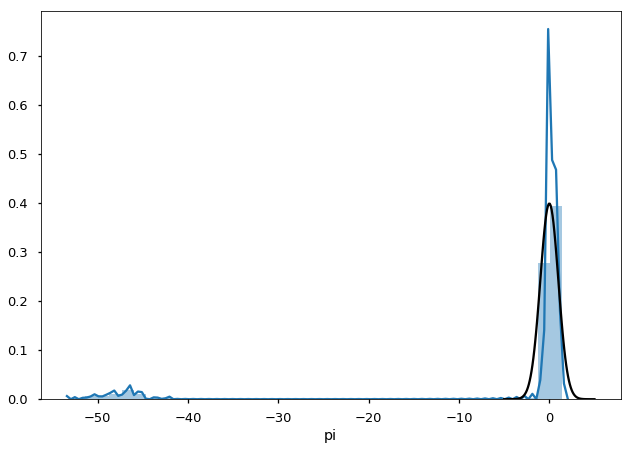

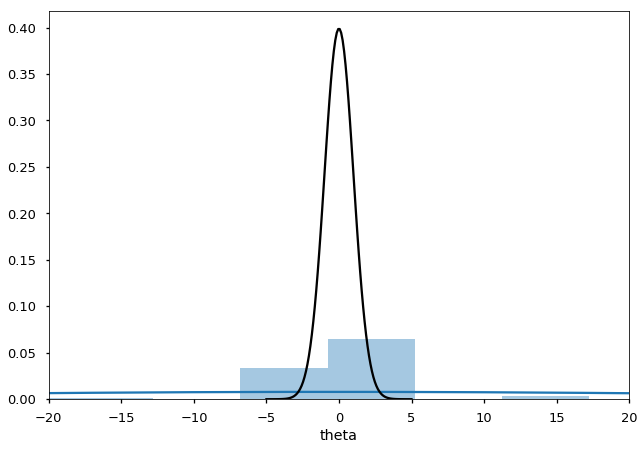

In [ ]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in est_arr[0][0].keys():
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

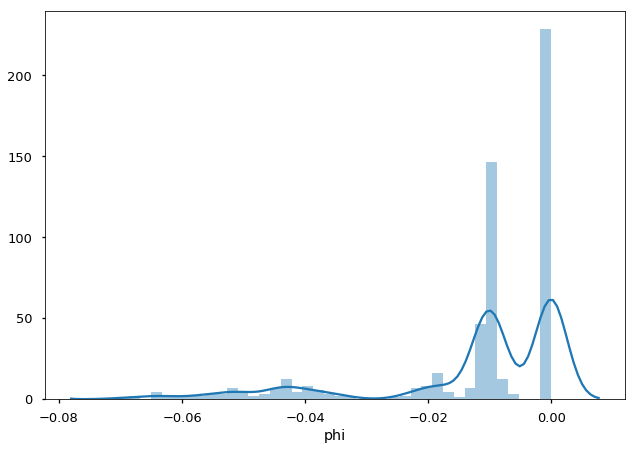

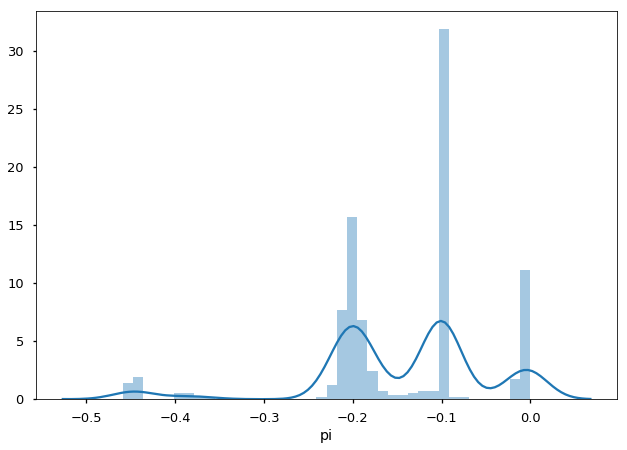

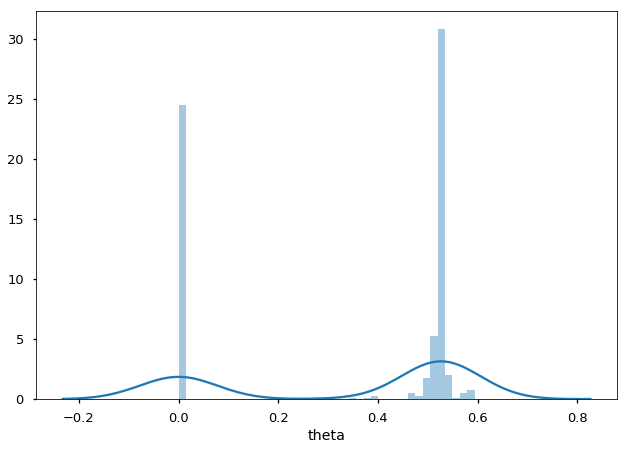

In [ ]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in ['phi', 'pi', 'theta']:
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([est[name] for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.set_xlabel(name)
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

# I now compute the robust conditional QLR statistic 

In [ ]:
omega


{'gamma': 0.004614451429674272,
 'beta': 0.005900243988004419,
 'psi': -0.031444238369545637,
 'zeta': 0.9975231300294848,
 'delta': 0.2695815632420677,
 'rho': 0.8105622288572095,
 'scale': 3.1331544340003497}

In [ ]:
true_params

{'delta': 0.27,
 'rho': 0.81,
 'scale': 3.11,
 'phi': -0.01,
 'pi': -0.2,
 'theta': 0.53}

In [ ]:
compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
                                                           true_params['theta']],
                      innov_dim=50, alpha=None, robust_quantile=True)

In [ ]:
# total=min(50, len(est_arr))
# with Pool(8) as pool:
#     results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_vals, 
#                                                                                     est_arr[:total]),
#                                                           total=total))))

In [ ]:
# results[results <=0] = 0 

In [ ]:
# robust_pit = cdpm.probability_integral_transform(evaluated_data = results.iloc[:,0].to_frame(),
#                                     reference_data=results.iloc[:,1:]).replace(np.inf, 1)

In [ ]:
# standard_pit = stats.chi2.cdf(results.iloc[:,0], df=3)

In [ ]:
# fig, ax = mpl.pyplot.subplots()
# cdpm.pit_plot(standard_pit, ax=ax, color='orange', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='standard')
# cdpm.pit_plot(robust_pit, ax=ax, color='blue', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='robust')
# ax.legend()
# fig.savefig('../doc/figures/asymptotic_dist_pitop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
#             frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

In [ ]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=innov_dim, alpha=0.05, case=1,
                                        robust_quantile=True)

In [ ]:
returnval.head()

In [ ]:
returnval.head()

In [ ]:
returnval.mean()

In [ ]:
true_params['phi']

In [52]:
 filename = '../results/reject_prop_kharpov_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)

In [53]:
filename

'../results/reject_prop_kharpov_250_-0.01_37000.json'

In [54]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
else:
    filename = '../results/reject_prop_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
    
returnval.to_json(filename)

In [55]:
returnval.mean()

qlr_stat               3.034844
robust_qlr_qauntile    7.558741
robust                 0.066000
standard               0.060000
dtype: float64

In [56]:
returnval.query('robust_qlr_qauntile > 0').mean()

qlr_stat               3.034844
robust_qlr_qauntile    7.558741
robust                 0.066000
standard               0.060000
dtype: float64

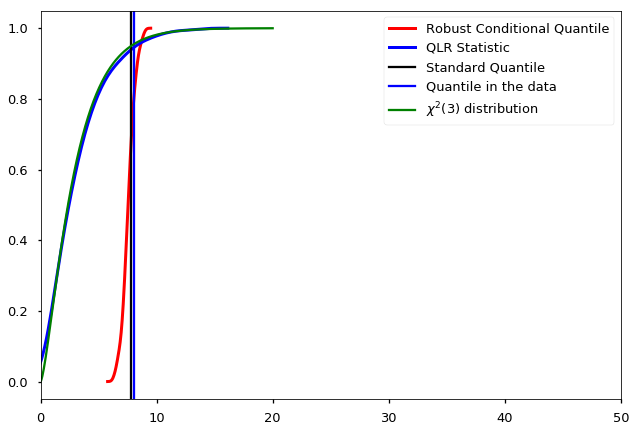

In [58]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)